# Real-Time Location System Case Study
## MSDS 7333 - Section 404
## Unit 6: Case Study

[Data Science @ Southern Methodist University](https://datascience.smu.edu/)

# Table of Contents
* [Team Members](#Team-Members)
* [Abstract](#Abstract)
* [Introduction](#Introduction)
* [Literature Review](#Literature-Review)
* [Background](#Background)
* [Methods](#Methods)
* [Results](#Results)
* [Future Work, Discussion, and Conclusion](#Conclusion)
* [References](#References)

# <a name="Team-Members"></a>Team Members
* [Jostein Barry-Straume](https://github.com/josteinstraume)

# <a name="Abstract"></a>Abstract

> In this case study, the reliability of and challenges faced when tracking devices and individuals within buildings is explored. The accuracy of including pseudo-redundant data when computing location predictions is compared and contrasted against removal of non-distinct access point recordings. Additionally, the error rates resulting from unweighted and weighted K-nearest neighbors are compared.

# <a name="Introduction"></a>Introduction

> The two datasets, 'offline' and 'online,' measure the signal strength of a hand-held device on a "grid of 166 points spaced 1 meter apart in the hallways of one floor of a building at the University of Mannheim" [1].

> The below image is the floor plan of how the various signal strengths, angles, and access points were recorded.

![Floor Plan of the Test Environment](../images/floor_plan_test_environment.png)

# <a name="Background"></a>Background

### Import Dataset

> In the below table are the variables contained in both the offline and online datasets, as well as their respective descriptions:

| Variable | Description |
| :------: | :-----------: |
| t | timestamp in milliseconds since midnight, January 1, 1970 UTC [1] |
| id | MAC address of the scanning device [1] |
| pos | the physical coordinate of the scanning device [1] |
| degree | orientation of the user carrying the scanning device in degrees [1] |
| MAC | MAC address of a responding peer (e.g., an access point or a device in adhoc mode) with the corresponding values for signal strength in dBm (Decibel-milliwatts), the channel frequency and its mode (access point = 3, device in adhoc mode = 1) [1] |



> The below code goes through the process of reading each line of the datasets in order to munge a meaningful data frame on which analysis can be conducted.

In [126]:
options(digits = 2)

txt = readLines("../data/offline_final_trace.txt")

In [128]:
lines = txt[ substr(txt, 1, 1) != "#" ]

processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  
  if (length(tokens) == 10) 
    return(NULL)
 
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6, 
               byrow = TRUE), tmp)
}

options(error = recover, warn = 1)
tmp = lapply(lines, processLine)
offline = as.data.frame(do.call("rbind", tmp), 
                        stringsAsFactors = FALSE)

In [129]:
dim(offline)

names(offline) = c("time", "scanMac", "posX", "posY", "posZ", 
                   "orientation", "mac", "signal", 
                   "channel", "type")

numVars = c("time", "posX", "posY", "posZ", 
            "orientation", "signal")
offline[ numVars ] =  lapply(offline[ numVars ], as.numeric)

offline = offline[ offline$type == "3", ]
offline = offline[ , "type" != names(offline) ]
dim(offline)

offline$rawTime = offline$time
offline$time = offline$time/1000
class(offline$time) = c("POSIXt", "POSIXct")

unlist(lapply(offline, class))

[1] 1181628      10

[1] 978443      9

time1       time2     scanMac        posX        posY        posZ 
   "POSIXt"   "POSIXct" "character"   "numeric"   "numeric"   "numeric" 
orientation         mac      signal     channel     rawTime 
  "numeric" "character"   "numeric" "character"   "numeric"

### Summary Statistics

> The summary statistics for each company are found below:

      time                          posX         posY           posZ  
 Min.   :2006-02-10 23:31:58   Min.   : 0   Min.   : 0.0   Min.   :0  
 1st Qu.:2006-02-11 05:21:27   1st Qu.: 2   1st Qu.: 3.0   1st Qu.:0  
 Median :2006-02-11 11:57:58   Median :12   Median : 6.0   Median :0  
 Mean   :2006-02-16 06:57:37   Mean   :14   Mean   : 5.9   Mean   :0  
 3rd Qu.:2006-02-19 06:52:40   3rd Qu.:23   3rd Qu.: 8.0   3rd Qu.:0  
 Max.   :2006-03-09 12:41:10   Max.   :33   Max.   :13.0   Max.   :0  
  orientation      signal   
 Min.   :  0   Min.   :-99  
 1st Qu.: 90   1st Qu.:-69  
 Median :180   Median :-60  
 Mean   :167   Mean   :-62  
 3rd Qu.:270   3rd Qu.:-53  
 Max.   :360   Max.   :-25  

                mac               channel                    scanMac      
 00:0f:a3:39:e1:c0:145862   2462000000:189774   00:02:2D:21:0F:33:978443  
 00:0f:a3:39:dd:cd:145619   2437000000:152124                             
 00:14:bf:b1:97:8a:132962   2412000000:145619                             
 00:14:bf:3b:c7:c6:126529   2432000000:126529                             
 00:14:bf:b1:97:90:122315   2427000000:122315                             
 00:14:bf:b1:97:8d:121325   2442000000:121325                             
 (Other)          :183831   (Other)   :120757                             

[1] 203

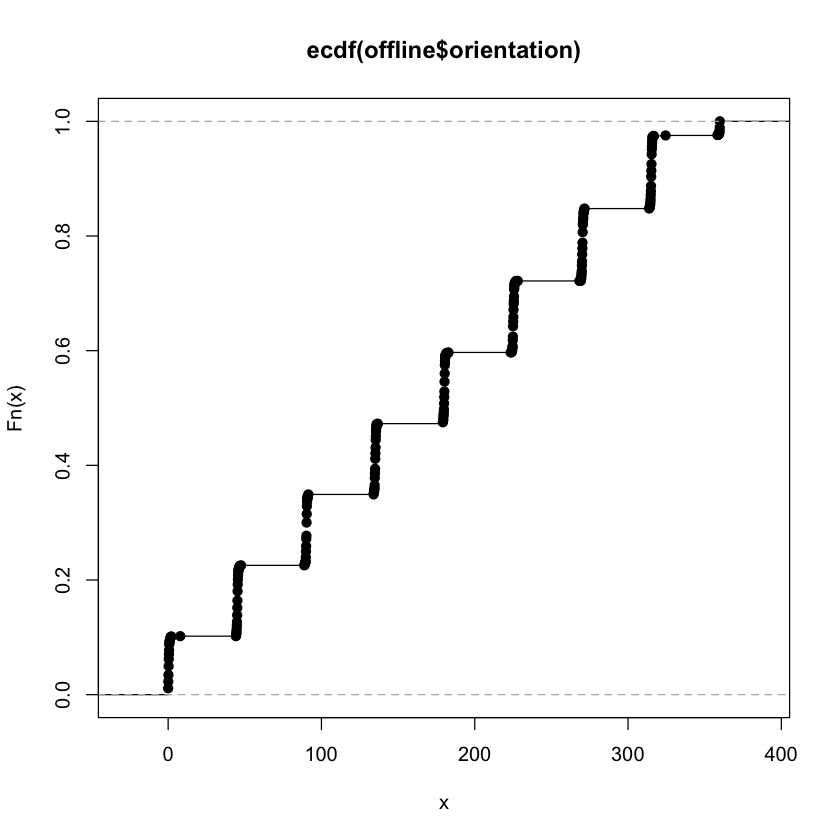

null device 
          1

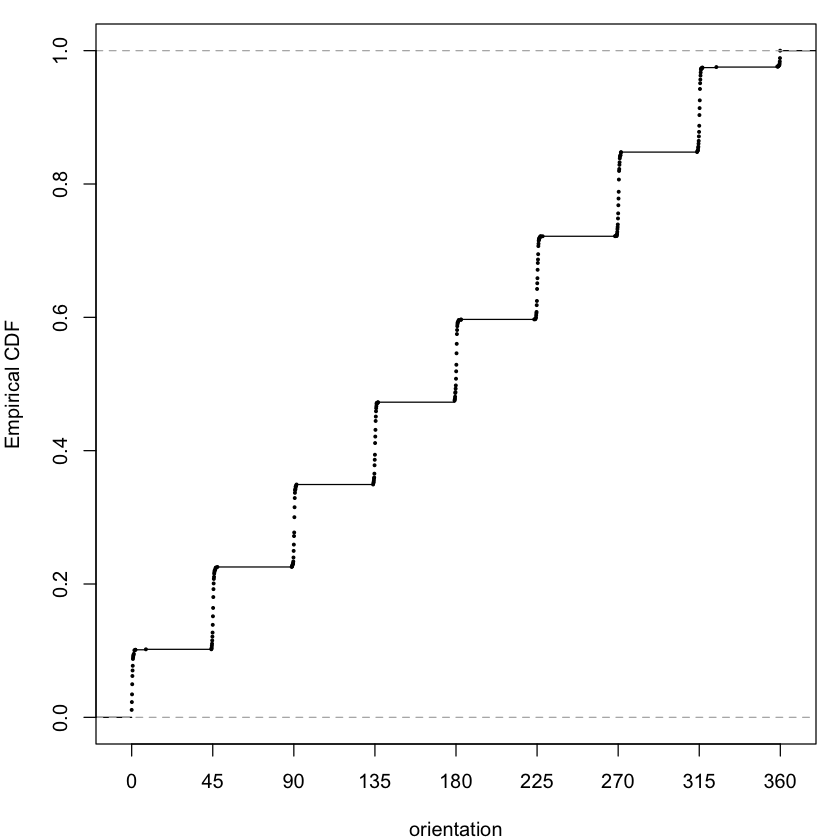

In [130]:
summary(offline[, numVars])

 summary(sapply(offline[ , c("mac", "channel", "scanMac")],
                as.factor))

offline = offline[ , !(names(offline) %in% c("scanMac", "posZ"))]

length(unique(offline$orientation))

plot(ecdf(offline$orientation))

#pdf(file = "Geo_ECDFOrientation.pdf", width = 10, height = 7)
oldPar = par(mar = c(4, 4, 1, 1))
plot(ecdf(offline$orientation), pch = 19, cex = 0.3,
     xlim = c(-5, 365), axes = FALSE,
     xlab = "orientation", ylab = "Empirical CDF", main = "")
box()
axis(2)
axis(side = 1, at = seq(0, 360, by = 45))
par(oldPar)
dev.off()

Warning message:
“In density.default(offline$orientation, bw = 2, sub = "Caption for the figure") :
 extra argument ‘sub’ will be disregarded”

null device 
          1

null device 
          1

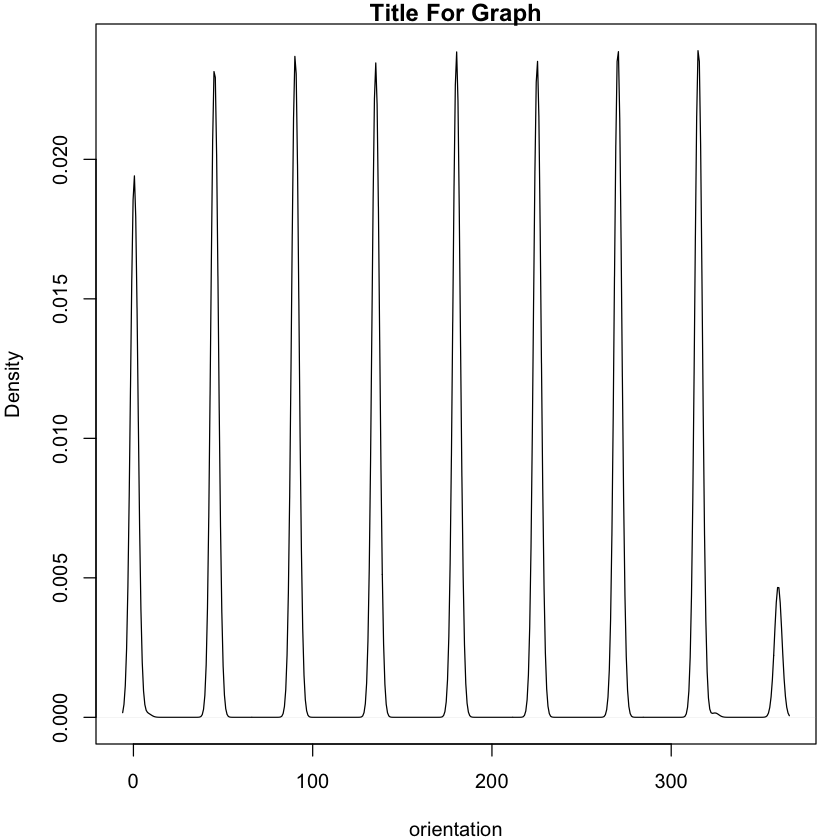

In [131]:
#pdf(file = "Geo_DensityOrientation.pdf", width = 10, height = 5)
oldPar = par(mar = c(4, 4, 1, 1))
plot(density(offline$orientation, bw = 2,sub="Caption for the figure"), 
 xlab = "orientation", main = "")
title("Title For Graph")

par(oldPar)
dev.off()

roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

offline$angle = roundOrientation(offline$orientation)

#pdf(file = "Geo_BoxplotAngle.pdf", width = 10)
oldPar = par(mar = c(4, 4, 1, 1))

par(oldPar)
dev.off()

In [132]:
c(length(unique(offline$mac)), length(unique(offline$channel)))

table(offline$mac)

subMacs = names(sort(table(offline$mac), decreasing = TRUE))[1:7]
offline = offline[ offline$mac %in% subMacs, ]

macChannel = with(offline, table(mac, channel))
apply(macChannel, 1, function(x) sum(x > 0))

offline = offline[ , "channel" != names(offline)]

locDF = with(offline, 
             by(offline, list(posX, posY), function(x) x))
length(locDF)


sum(sapply(locDF, is.null))



[1] 12  8


00:04:0e:5c:23:fc 00:0f:a3:39:dd:cd 00:0f:a3:39:e0:4b 00:0f:a3:39:e1:c0 
              418            145619             43508            145862 
00:0f:a3:39:e2:10 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
            19162            126529            120339            132962 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 00:30:bd:f8:7f:c5 00:e0:63:82:8b:a9 
           121325            122315               301               103 

00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
                1                 1                 1                 1 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1                 1

[1] 476

[1] 310

# <a name="Methods"></a>Methods

> 

[1] 166

[1] "matrix"

[1]   3 166

[,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
posX  0    1    2    0    1    2    0    1   
posY  0    0    0    1    1    1    2    2   
count 5505 5505 5506 5524 5543 5558 5503 5564

null device 
          1

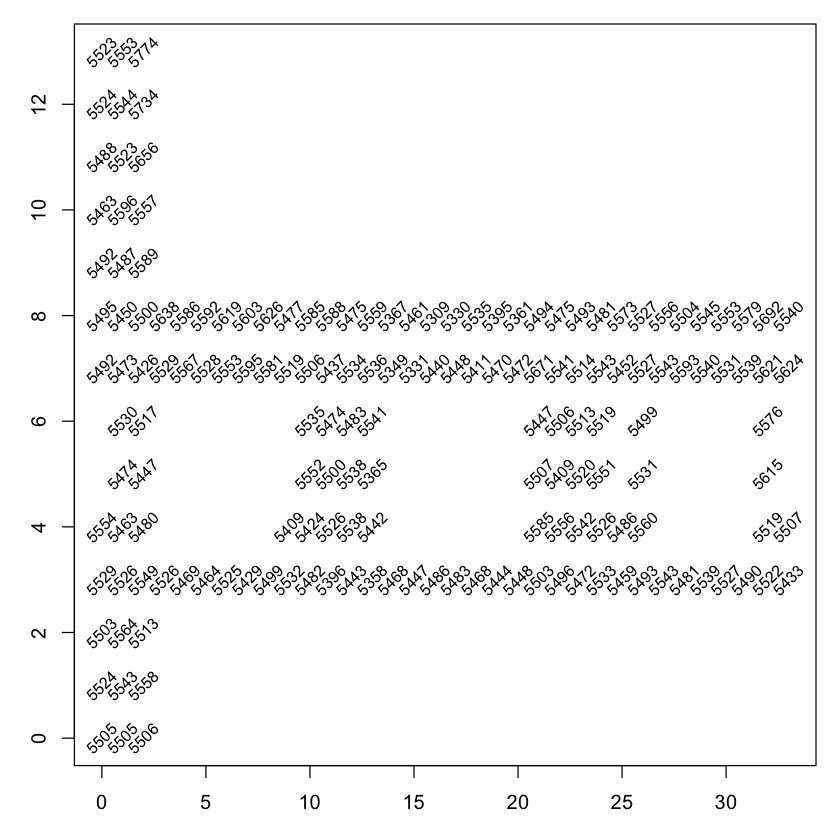

In [133]:
locDF = locDF[ !sapply(locDF, is.null) ]

length(locDF)

locCounts = sapply(locDF, nrow)

locCounts = sapply(locDF, 
                   function(df) 
                     c(df[1, c("posX", "posY")], count = nrow(df)))

class(locCounts)

dim(locCounts)

locCounts[ , 1:8]

#pdf(file = "Geo_XYByCount.pdf", width = 10)
oldPar = par(mar = c(3.1, 3.1, 1, 1))

locCounts = t(locCounts)
plot(locCounts, type = "n", xlab = "", ylab = "")
text(locCounts, labels = locCounts[,3], cex = .8, srt = 45)

par(oldPar)
dev.off()

In [134]:

readData = 
  function(filename = '../data/offline_final_trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }

offlineRedo = readData()

identical(offline, offlineRedo)

[1] TRUE

null device 
          1

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    -98     -67     -59     -60     -53     -25 

null device 
          1

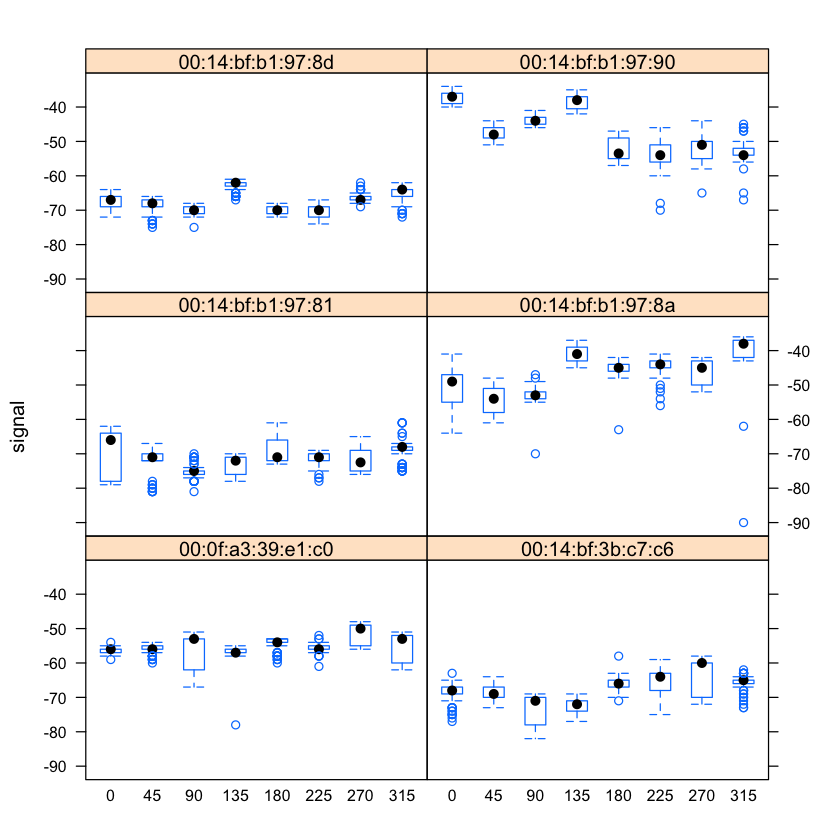

In [135]:
oldPar = par(mar = c(3.1, 3, 1, 1))

library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offline, 
       subset = posX == 2 & posY == 12 
                & mac != "00:0f:a3:39:dd:cd"
       ,layout = c(2,3))

par(oldPar)
dev.off()

summary(offline$signal)

#pdf(file = "Geo_DensitySignalByMacAngle.pdf", width = 8, height = 12)
oldPar = par(mar = c(3.1, 3, 1, 1))

densityplot( ~ signal | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4 
                & mac != "00:0f:a3:39:dd:cd"
             ,bw = 0.5, plot.points = FALSE)

par(oldPar)
dev.off()

### KNN Section
#### Removing "00:0f:a3:39:dd:cd" MAC address

In [163]:
# ANOTHER KEY LINE COMMENTED OUT
#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

offline$posXY = paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary = do.call("rbind", signalSummary)  

null device 
          1

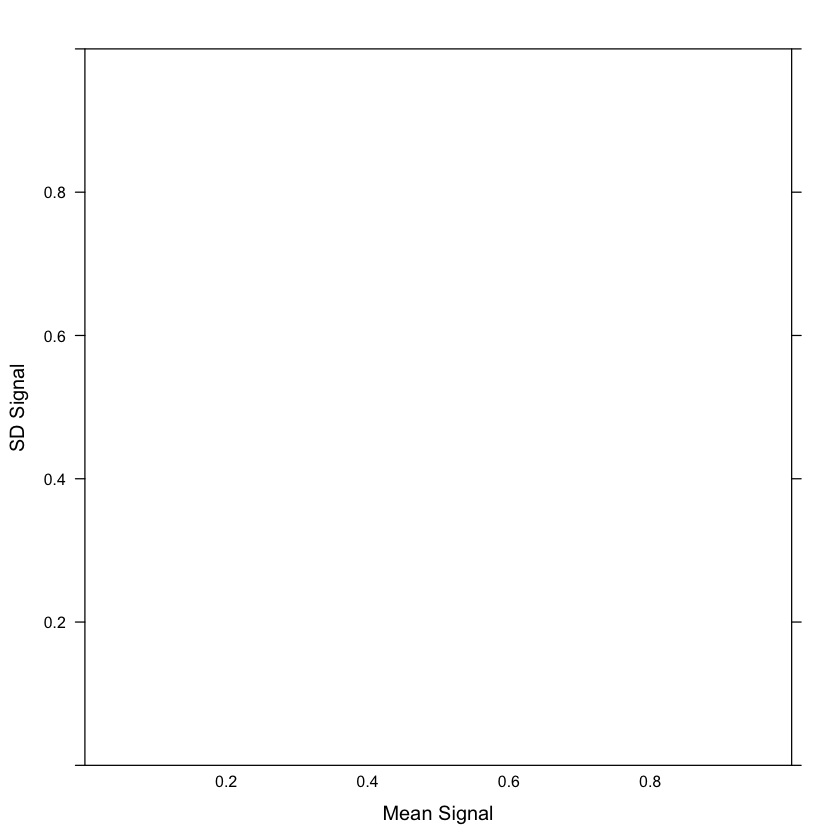

In [164]:
#pdf(file = "Geo_BoxplotSignalSDByAvg.pdf", width = 10)
oldPar = par(mar = c(3.1, 3, 1, 1))

breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary, 
       subset = mac # != "00:0f:a3:39:dd:cd",
       ,xlab = "Mean Signal", ylab = "SD Signal")

par(oldPar)
dev.off()

null device 
          1

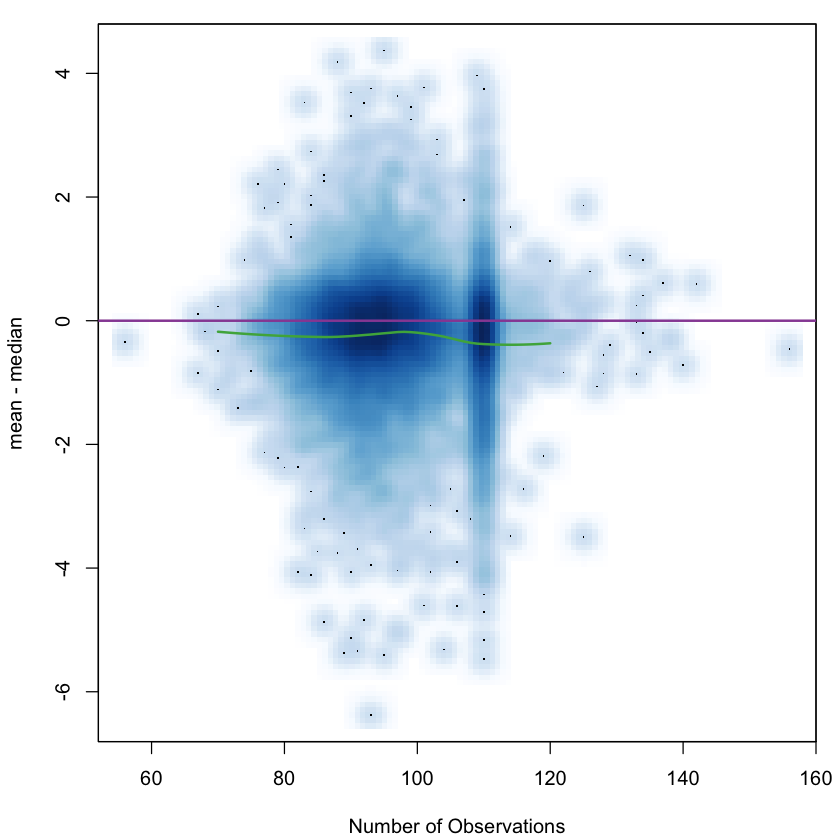

In [165]:
#pdf(file = "Geo_ScatterMean-Median.pdf", width = 10)
oldPar = par(mar = c(4.1, 4.1, 1, 1))

with(offlineSummary,
     smoothScatter((avgSignal - medSignal) ~ num,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)

lo.obj = 
  with(offlineSummary,
       loess(diff ~ num, 
             data = data.frame(diff = (avgSignal - medSignal),
                               num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

par(oldPar)
dev.off()
 
oneAPAngle = subset(offlineSummary, 
                    mac == subMacs[5] & angle == 0)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


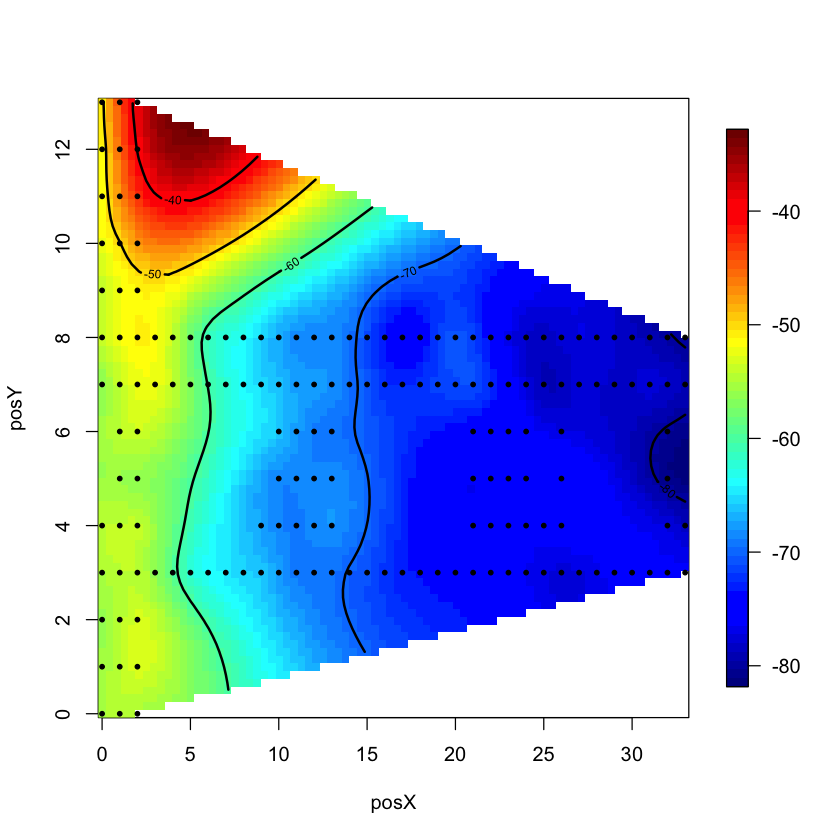

In [166]:
install.packages('fields')
library(fields)
smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
               oneAPAngle$avgSignal)

vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")

points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)



In [167]:
unique(offlineSummary$mac)

[1] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[4] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

ERROR while rich displaying an object: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[1]]) result is length 0

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_html.list(obj)
9. repr_list_generic(obj, "html", "\t<li>%s</li>\n", "\t<dt>$%s</dt>\n\t\t<dd>%s</dd>\n", 
 .     "<strong>$%s</strong> = %s", "<ol>\n%s</ol>\n", "<dl>\n%s</dl>\n", 
 .     numeric_item = "\t<dt>[[%s]]</dt>\n\t\

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL


x    y   
00:0f:a3:39:e1:c0  7.5  6.3
00:14:bf:b1:97:8a  2.5 -0.8
00:14:bf:3b:c7:c6 12.8 -2.8
00:14:bf:b1:97:90  1.0 14.0
00:14:bf:b1:97:8d 33.5  9.3
00:14:bf:b1:97:81 33.5  2.8

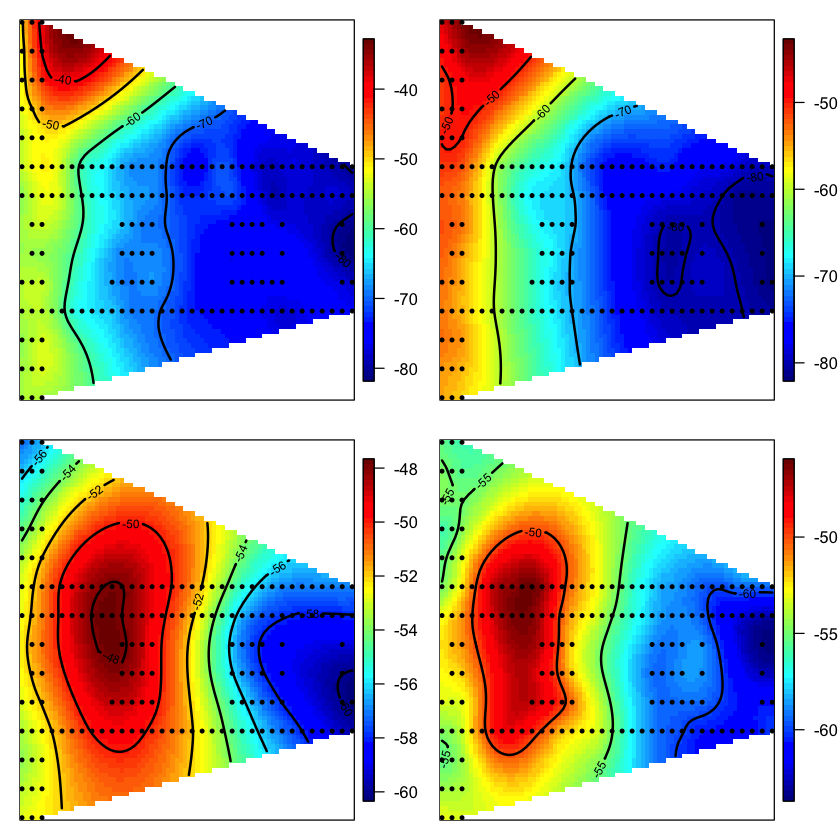

In [168]:
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

parCur = par(mfrow = c(2,2), mar = rep(1, 4))

mapply(surfaceSS, mac = subMacs[ rep(c(5, 1), each = 2) ], 
       angle = rep(c(0, 135), 2),
       data = list(data = offlineSummary))
 
par(parCur)

offlineSummary = subset(offlineSummary, mac != subMacs[2])

AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(subMacs[ -2 ], c("x", "y") ))

AP

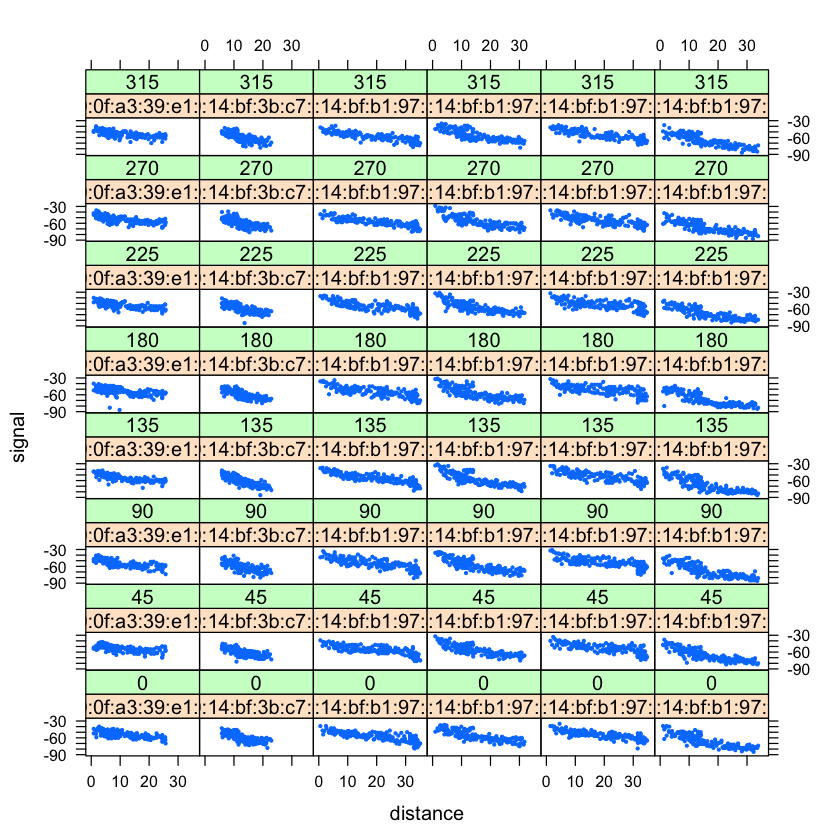

null device 
          1

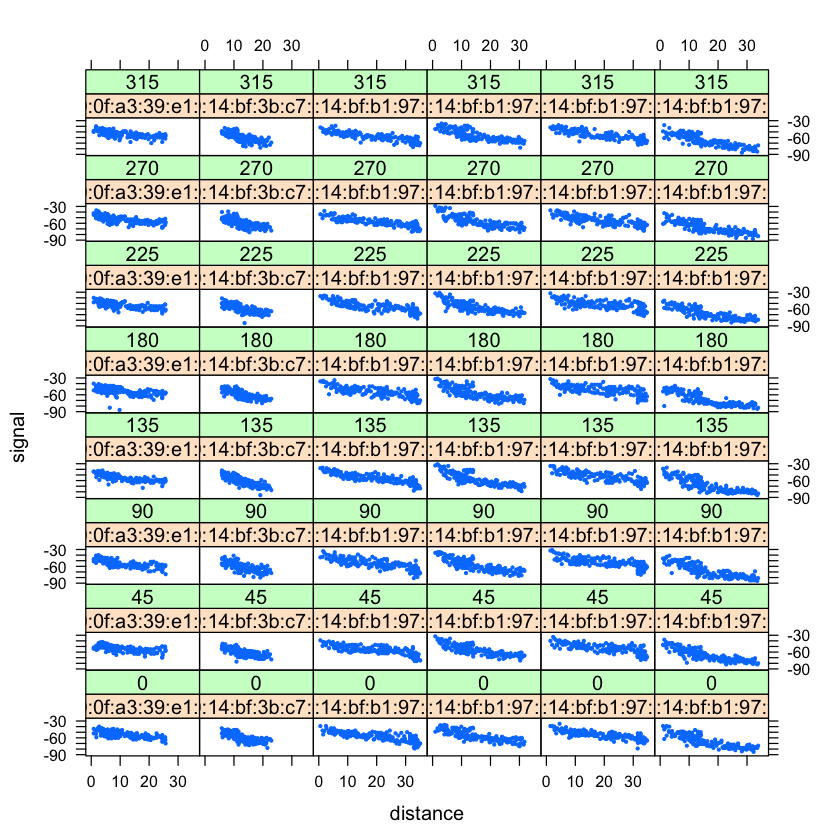

In [169]:
diffs = offlineSummary[ , c("posX", "posY")] - 
          AP[ offlineSummary$mac, ]

offlineSummary$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)

xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")

#pdf(file="Geo_ScatterSignalDist.pdf", width = 7, height = 10)
oldPar = par(mar = c(3.1, 3.1, 1, 1))
library(lattice)
xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")
par(oldPar)
dev.off()

macs = unique(offlineSummary$mac)

In [198]:
macs[7] = "00:0f:a3:39:dd:cd"
macs
#unique(subMacs)

[1] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[4] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"
[7] "00:0f:a3:39:dd:cd"

### Nearest Neighbor Methods to Predict Location

In [199]:
online = readData("../data/offline_final_trace.txt", subMacs = macs)

online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:7, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 7,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  



[1] 166

      
         0  45  90 135 180 225 270 315
  0-0  693 668 678 696 719 684 681 686
  0-1  669 689 674 703 711 695 713 670
  0-10 680 712 653 667 705 686 669 691
  0-11 708 657 698 693 671 678 675 708
  0-12 694 712 675 700 685 691 688 679
  0-13 688 718 694 683 670 700 696 674
  0-2  681 663 699 696 690 692 690 692

In [201]:
names(onlineSummary)

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:dd:cd"
 [7] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[10] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [202]:
dim(onlineSummary)

names(onlineSummary)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

[1] 166  12

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:dd:cd"
 [7] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[10] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [209]:
list(ans$posXY,names(avgSS))

ERROR: Error in eval(expr, envir, enclos): object 'ans' not found


In [211]:
names(offlineSummary)

[1] "time"        "posX"        "posY"        "orientation" "mac"        
 [6] "signal"      "rawTime"     "angle"       "posXY"       "medSignal"  
[11] "avgSignal"   "num"         "sdSignal"    "iqrSignal"   "dist"

In [213]:
offlineSummary[1,]

time                posX posY orientation mac               signal rawTime
3 2006-02-10 23:31:58 0    0    0           00:0f:a3:39:e1:c0 -53    1.1e+12
  angle posXY medSignal avgSignal num sdSignal iqrSignal dist
3 0     0-0   -51       -51       110 1.4      2         9.8

In [214]:
onlineSummary[1,]

posXY posX posY orientation angle 00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0
0-0 0-0   0    0    0           0     -70               -53              
    00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 00:14:bf:b1:97:8d
0-0 -66               -64               -39               -66              
    00:14:bf:b1:97:90
0-0 -56

In [215]:
offlineSubset = 
  offlineSummary[ offlineSummary$angle %in% angles, ]

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

In [216]:
selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

In [219]:
train130 = selectTrain(130, offlineSummary, m = 3)

head(train130)

length(train130[[1]])

findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}



posXY posX posY 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81
0-0  0-0   0     0   -52               -66               -63              
0-1  0-1   0     1   -53               -65               -64              
0-10 0-10  0    10   -56               -66               -69              
0-11 0-11  0    11   -55               -67               -70              
0-12 0-12  0    12   -56               -70               -72              
0-13 0-13  0    13   -55               -71               -73              
     00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90
0-0  -36               -64               -55              
0-1  -39               -65               -59              
0-10 -45               -67               -50              
0-11 -48               -67               -55              
0-12 -45               -67               -50              
0-13 -43               -69               -54

[1] 166

In [232]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}
estXYk3 = predXY(newSignals = onlineSummary[ , 6:12], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

estXYk1 = predXY(newSignals = onlineSummary[ , 6:12], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)



Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning me

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

In [177]:
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

trainPoints = offlineSummary[ offlineSummary$angle == 0 & 
                              offlineSummary$mac == "00:0f:a3:39:e1:c0" ,
                        c("posX", "posY")]

null device 
          1

null device 
          1

[1] 517 387

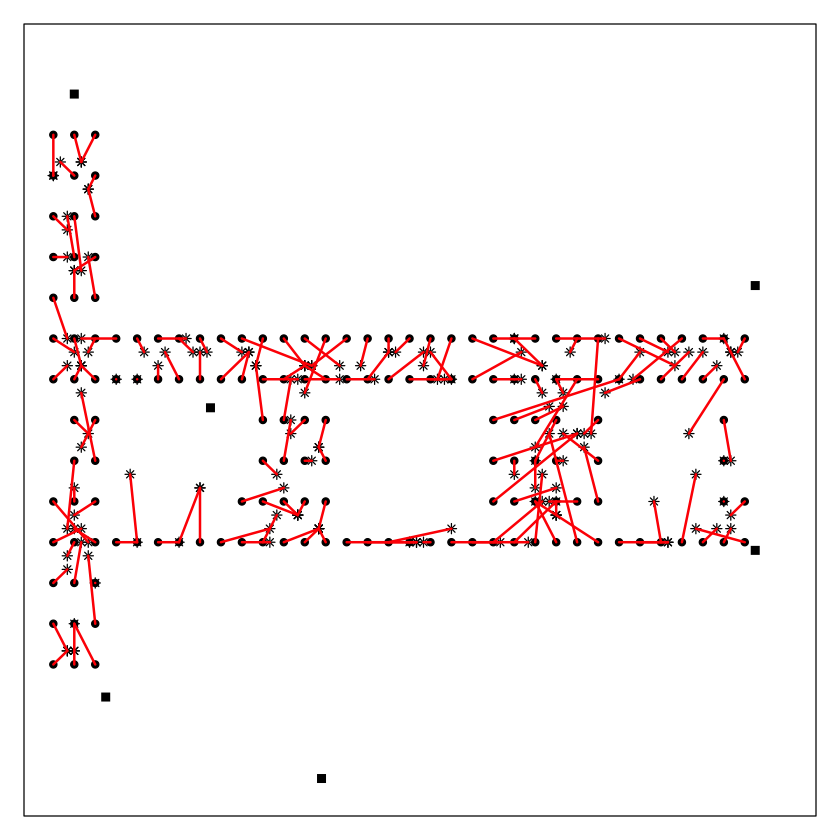

In [178]:
#pdf(file="GEO_FloorPlanK3Errors.pdf", width = 10, height = 7)
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

#pdf(file="GEO_FloorPlanK1Errors.pdf", width = 10, height = 7)
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)

In [179]:
v = 11
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
“data length [166] is not a sub-multiple or multiple of the number of rows [15]”

In [180]:
names(onlineSummary)

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:e1:c0"
 [7] "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a"
[10] "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [181]:
sum(offline$mac == "00:0f:a3:39:dd:cd")

[1] 0

In [182]:
##### KEY LINE HERE
#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline, keepVars = keepVars, 
                            sampleAngle = TRUE)

onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

In [183]:
actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

[1] 232

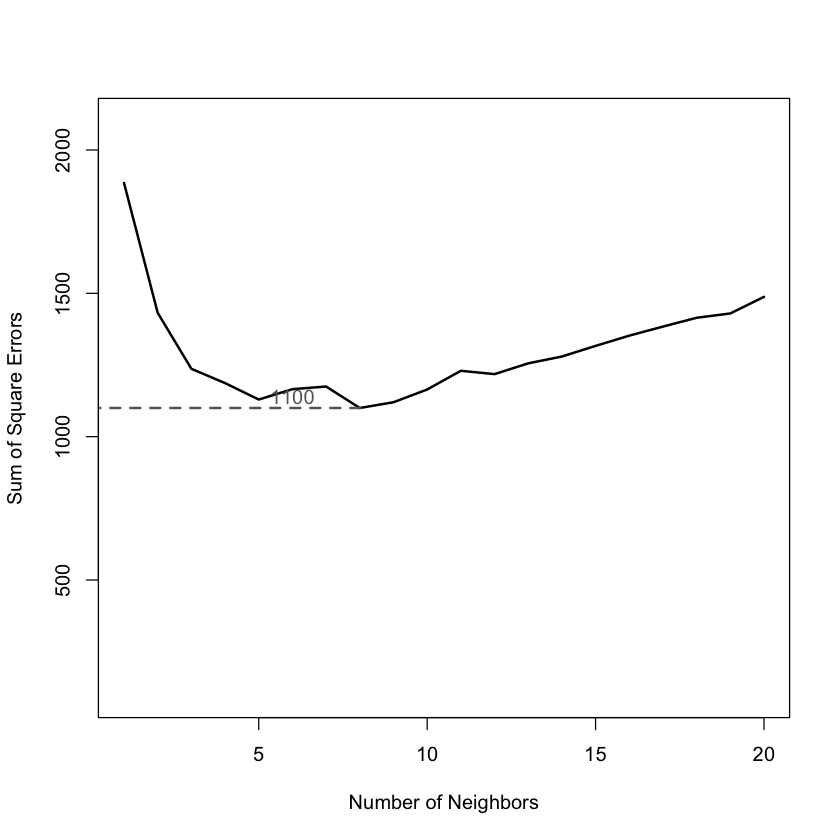

In [184]:
#pdf(file = "Geo_CVChoiceOfK.pdf", width = 10, height = 6)
#oldPar = par(mar = c(4, 3, 1, 1))
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(100, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))
#par(oldPar)
#dev.off()

In [185]:
#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))


estXYk5 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 5)

calcError(estXYk5, actualXY)

[1] 393

In [186]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = findNN(newSignal = as.numeric(newSignals[i, ]),
                           trainSS)
  }

  estXY = lapply(closeXY, function(x)
                            sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

In [222]:
onlineSummary[1,]

posXY posX posY orientation angle 00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0
0-0 0-0   0    0    0           0     -70               -53              
    00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 00:14:bf:b1:97:8d
0-0 -66               -64               -39               -66              
    00:14:bf:b1:97:90
0-0 -56

In [221]:
offlineSummary[1,]

time                posX posY orientation mac               signal rawTime
3 2006-02-10 23:31:58 0    0    0           00:0f:a3:39:e1:c0 -53    1.1e+12
  angle posXY medSignal avgSignal num sdSignal iqrSignal dist
3 0     0-0   -51       -51       110 1.4      2         9.8

In [189]:
online[1,]

time                posX posY orientation mac               signal rawTime
1 2006-02-10 23:31:58 0    0    0           00:14:bf:b1:97:8a -38    1.1e+12
  angle posXY
1 0     0-0

In [220]:
offline[1,]

time                posX posY orientation mac               signal rawTime
1 2006-02-10 23:31:58 0    0    0           00:14:bf:b1:97:8a -38    1.1e+12
  angle posXY
1 0     0-0

In [191]:
macs = unique(offlineSummary$mac)
macs

[1] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[4] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [193]:
class(macs)

[1] "character"

In [194]:
macs[1]

[1] "00:0f:a3:39:e1:c0"

In [195]:
macs[7] = "00:0f:a3:39:dd:cd"

In [224]:
macs

[1] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[4] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"
[7] "00:0f:a3:39:dd:cd"

In [226]:
length(names(onlineSummary))

[1] 12

In [230]:
names(onlineSummary)

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:dd:cd"
 [7] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[10] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [231]:
estXYk5 = predXY(newSignals = onlineSummary[ , 6:12], 
                 newAngles = onlineSummary[ , 5], 
                 offlineSummary, numAngles = 3, k = 5)

calcError(estXYk5, actualXY)

Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning me

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer object length is not a multiple of shorter object length”Warning message in x - newSignal:
“longer ob

# With Both MAC Addresses

In [260]:
offlineRedo = readData()

offlineRedo$posXY = paste(offlineRedo$posX, offlineRedo$posY, sep = "-")

byLocAngleAP = with(offlineRedo, 
                    by(offlineRedo, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummaryRedo = do.call("rbind", signalSummary)

In [261]:
macs = unique(offlineSummaryRedo$mac)
onlineRedo = readData("../data/online_final_trace.txt", subMacs = macs)

onlineRedo$posXY = paste(onlineRedo$posX, onlineRedo$posY, sep = "-")

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(onlineRedo, 
             by(onlineRedo, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 7,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummaryRedo = do.call("rbind", byLoc)

offlineSubsetRedo = offlineSummaryRedo[ offlineSummaryRedo$angle %in% angles, ]

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 7,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

trainSS = reshapeSS(offlineSubsetRedo, varSignal = "avgSignal")

selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubsetRedo = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubsetRedo, varSignal = "avgSignal")
}

keepVars = c("posXY", "posX", "posY", "orientation", "angle")
onlineCVSummaryRedo = reshapeSS(offlineRedo, keepVars = keepVars,
                            sampleAngle = TRUE)

In [262]:
names(onlineSummary)

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:dd:cd"
 [7] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[10] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [263]:
K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFoldRedo = subset(onlineCVSummaryRedo, 
                      posXY %in% permuteLocs[ , j])
  offlineFoldRedo = subset(offlineSummaryRedo,
                       posXY %in% permuteLocs[ , -j])
  actualFoldRedo = onlineFoldRedo[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFoldRedo = predXY(newSignals = onlineFoldRedo[ , 6:11],
                     newAngles = onlineFoldRedo[ , 4], 
                     offlineFoldRedo, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFoldRedo, actualFoldRedo)
  }
}

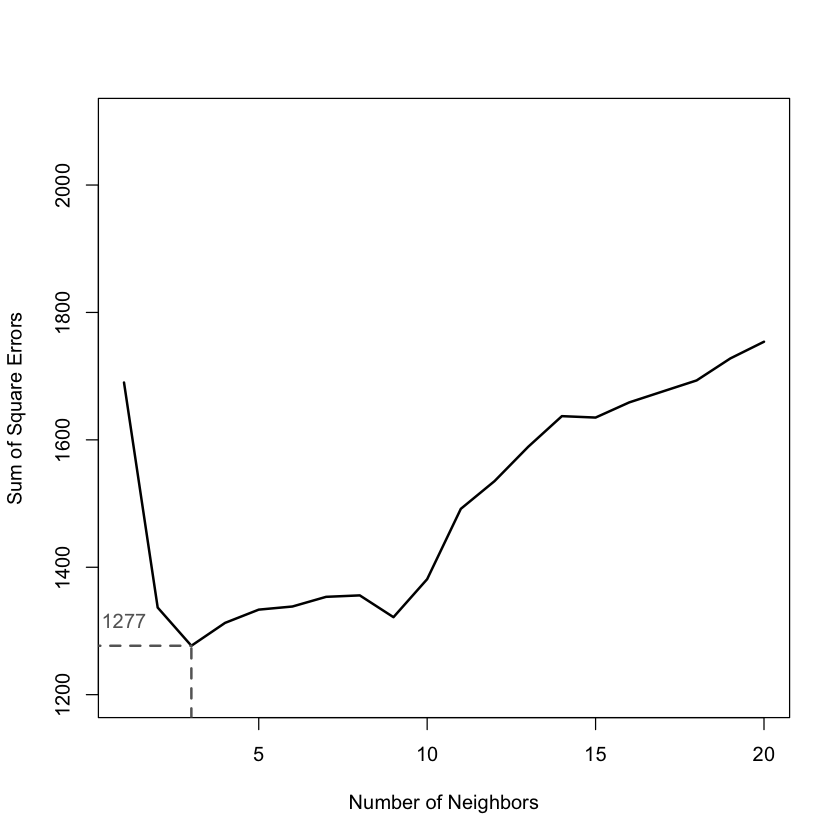

In [264]:
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(1200, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

In [265]:
actualXYRedo = onlineSummaryRedo[ , c("posX", "posY")]

estXYk3 = predXY(newSignals = onlineSummaryRedo[ , 6:11],
                 newAngles = onlineSummaryRedo[ , 4],
                 offlineSummaryRedo, numAngles = 3, k = 3)

errorRateWithBoth = calcError(estXYk3, actualXYRedo)
errorRateWithBoth

[1] 244

> The error rate using both "00:0f:a3:39:dd:cd" and "00:0f:a3:39:dd:cd" has an error rate of approximately 244.21. This error rate will be compared to two subsequently calculated error rates in the results section. Now let's subset the dataset to include the MAC address "00:0f:a3:39:dd:cd" and exclude the MAC address "00:0f:a3:39:e1:c0."

# Without the MAC Address "00:0f:a3:39:e1:c0"

In [241]:
offlineRedo2 = offlineRedo[ offlineRedo$mac != "00:0f:a3:39:e1:c0", ]


offlineRedo2$posXY = paste(offlineRedo2$posX, offlineRedo2$posY, sep = "-")

byLocAngleAP = with(offlineRedo2, 
                    by(offlineRedo2, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummaryRedo2 = do.call("rbind", signalSummary)



In [243]:
macs = unique(offlineSummaryRedo2$mac)
onlineRedo2 = readData("../data/online_final_trace.txt", subMacs = macs)

onlineRedo2$posXY = paste(onlineRedo2$posX, onlineRedo2$posY, sep = "-")

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(onlineRedo2, 
             by(onlineRedo2, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummaryRedo2 = do.call("rbind", byLoc)

offlineSubsetRedo2 = offlineSummaryRedo2[ offlineSummaryRedo2$angle %in% angles, ]

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

trainSS = reshapeSS(offlineSubsetRedo2, varSignal = "avgSignal")

selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubsetRedo2 = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubsetRedo2, varSignal = "avgSignal")
}

keepVars = c("posXY", "posX", "posY", "orientation", "angle")
onlineCVSummaryRedo2 = reshapeSS(offlineRedo2, keepVars = keepVars,
                            sampleAngle = TRUE)

In [244]:
K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFoldRedo2 = subset(onlineCVSummaryRedo2, 
                      posXY %in% permuteLocs[ , j])
  offlineFoldRedo2 = subset(offlineSummaryRedo2,
                       posXY %in% permuteLocs[ , -j])
  actualFoldRedo2 = onlineFoldRedo2[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFoldRedo2 = predXY(newSignals = onlineFoldRedo2[ , 6:11],
                     newAngles = onlineFoldRedo2[ , 4], 
                     offlineFoldRedo2, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFoldRedo2, actualFoldRedo2)
  }
}


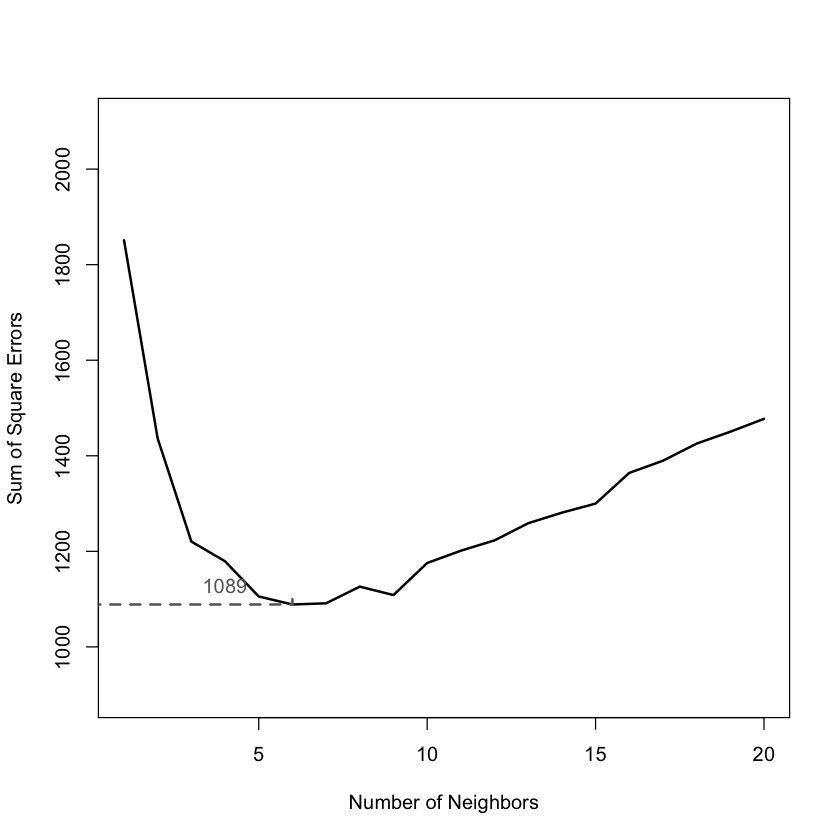

In [245]:
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(900, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

In [256]:
actualXYRedo2 = onlineSummaryRedo2[ , c("posX", "posY")]

estXYk6 = predXY(newSignals = onlineSummaryRedo2[ , 6:11],
                 newAngles = onlineSummaryRedo2[ , 4],
                 offlineSummaryRedo2, numAngles = 3, k = 6)

errorRateSansC0 = calcError(estXYk6, actualXYRedo2)
errorRateSansC0

[1] 252

> The error rate sans the MAC address "00:0f:a3:39:e1:c0" has an error rate of approximately 252.34. This error rate will be compared to the previous and subsequent error rates in the results section. Now let's reimport the dataset to include the MAC address "00:0f:a3:39:e1:c0" and exclude the MAC address "00:0f:a3:39:dd:cd."

# Without the MAC Address "00:0f:a3:39:dd:cd"

In [247]:
offlineRedo3 = offlineRedo[ offlineRedo$mac != "00:0f:a3:39:dd:cd", ]


offlineRedo3$posXY = paste(offlineRedo3$posX, offlineRedo3$posY, sep = "-")

byLocAngleAP = with(offlineRedo3, 
                    by(offlineRedo3, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummaryRedo3 = do.call("rbind", signalSummary)



In [248]:
macs = unique(offlineSummaryRedo3$mac)
onlineRedo3 = readData("../data/online_final_trace.txt", subMacs = macs)

onlineRedo3$posXY = paste(onlineRedo3$posX, onlineRedo3$posY, sep = "-")

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(onlineRedo3, 
             by(onlineRedo3, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummaryRedo3 = do.call("rbind", byLoc)

offlineSubsetRedo3 = offlineSummaryRedo3[ offlineSummaryRedo3$angle %in% angles, ]

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

trainSS = reshapeSS(offlineSubsetRedo3, varSignal = "avgSignal")

selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubsetRedo3 = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubsetRedo3, varSignal = "avgSignal")
}

keepVars = c("posXY", "posX", "posY", "orientation", "angle")
onlineCVSummaryRedo3 = reshapeSS(offlineRedo3, keepVars = keepVars,
                            sampleAngle = TRUE)

In [250]:
K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFoldRedo3 = subset(onlineCVSummaryRedo3, 
                      posXY %in% permuteLocs[ , j])
  offlineFoldRedo3 = subset(offlineSummaryRedo3,
                       posXY %in% permuteLocs[ , -j])
  actualFoldRedo3 = onlineFoldRedo3[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFoldRedo3 = predXY(newSignals = onlineFoldRedo3[ , 6:11],
                     newAngles = onlineFoldRedo3[ , 4], 
                     offlineFoldRedo3, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFoldRedo3, actualFoldRedo3)
  }
}


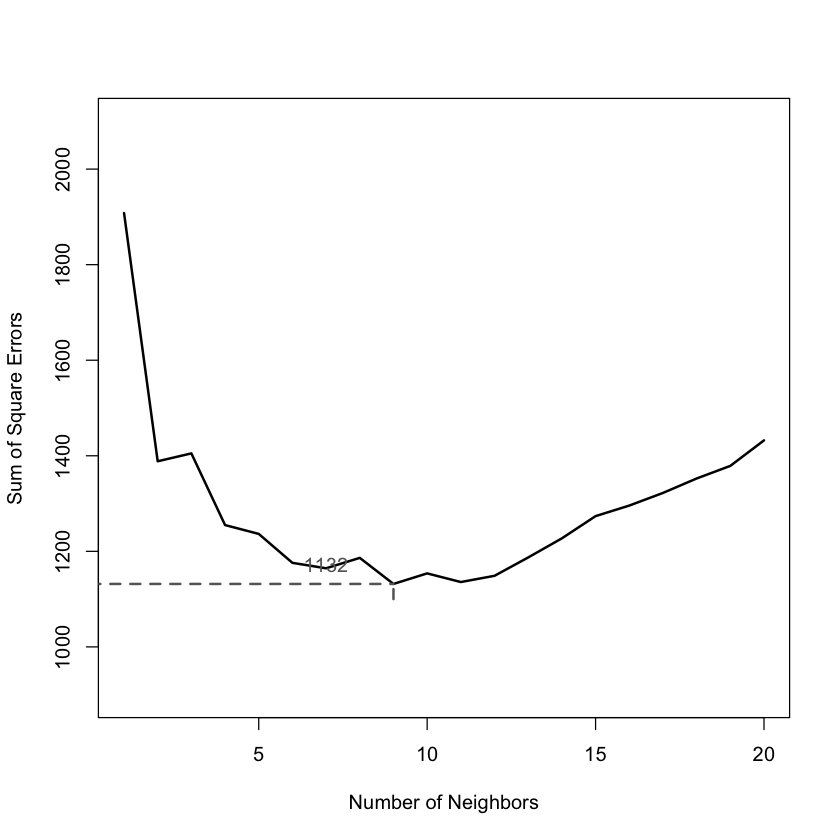

In [251]:
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(900, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

In [255]:
actualXYRedo3 = onlineSummaryRedo3[ , c("posX", "posY")]

estXYk10 = predXY(newSignals = onlineSummaryRedo3[ , 6:11],
                 newAngles = onlineSummaryRedo3[ , 4],
                 offlineSummaryRedo3, numAngles = 3, k = 10)

errorRateSansCD = calcError(estXYk10, actualXYRedo3)
errorRateSansCD

[1] 296

> The error rate sans the MAC address "00:0f:a3:39:dd:cd" has an error rate of approximately 296.46. This error rate will be compared to the previous two error rates in the results section. A K value of 10 was found to result in the lowest sum of square errors, and hence was chosen to compute the X-Y coordinate errors.

# Results

> The error rates for each scenario of this case study are shown below:

| Dataset | Error Rate |
| :-----: | :--------: |
| errorRateWithBoth | 244.206966666667 |
| errorRateSansC0 | 252.336966666667 |
| errorRateSansCD | 296.4563 |

> Of the two MAC addresses, "00:0f:a3:39:e1:c0" and "00:0f:a3:39:dd:cd", the former yields the better prediction of location. Consequently, given the choice between the two, the MAC address "00:0f:a3:39:e1:c0" should be used over "00:0f:a3:39:dd:cd" due to its lower error rate. However, as reflected in the below table, using the data for both MAC addresses simultaneously yield more accurate prediction of location. With this in mind, the dataset containing both MAC addresses will be used to compute the weighted K-nearest neighbors.

# Weighted KNN

In [300]:
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) (x - newSignal))
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

In [292]:
offlineRedo = readData()

offlineRedo$posXY = paste(offlineRedo$posX, offlineRedo$posY, sep = "-")

byLocAngleAP = with(offlineRedo, 
                    by(offlineRedo, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummaryRedo = do.call("rbind", signalSummary)

In [293]:
macs = unique(offlineSummaryRedo$mac)
onlineRedo = readData("../data/online_final_trace.txt", subMacs = macs)

onlineRedo$posXY = paste(onlineRedo$posX, onlineRedo$posY, sep = "-")

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(onlineRedo, 
             by(onlineRedo, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 7,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummaryRedo = do.call("rbind", byLoc)

offlineSubsetRedo = offlineSummaryRedo[ offlineSummaryRedo$angle %in% angles, ]

reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 7,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

trainSS = reshapeSS(offlineSubsetRedo, varSignal = "avgSignal")

selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubsetRedo = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubsetRedo, varSignal = "avgSignal")
}

keepVars = c("posXY", "posX", "posY", "orientation", "angle")
onlineCVSummaryRedo = reshapeSS(offlineRedo, keepVars = keepVars,
                            sampleAngle = TRUE)

In [294]:
names(onlineSummary)

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:dd:cd"
 [7] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[10] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [302]:
K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFoldRedo = subset(onlineCVSummaryRedo, 
                      posXY %in% permuteLocs[ , j])
  offlineFoldRedo = subset(offlineSummaryRedo,
                       posXY %in% permuteLocs[ , -j])
  actualFoldRedo = onlineFoldRedo[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFoldRedo = predXY(newSignals = onlineFoldRedo[ , 6:11],
                     newAngles = onlineFoldRedo[ , 4], 
                     offlineFoldRedo, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFoldRedo, actualFoldRedo)
  }
}

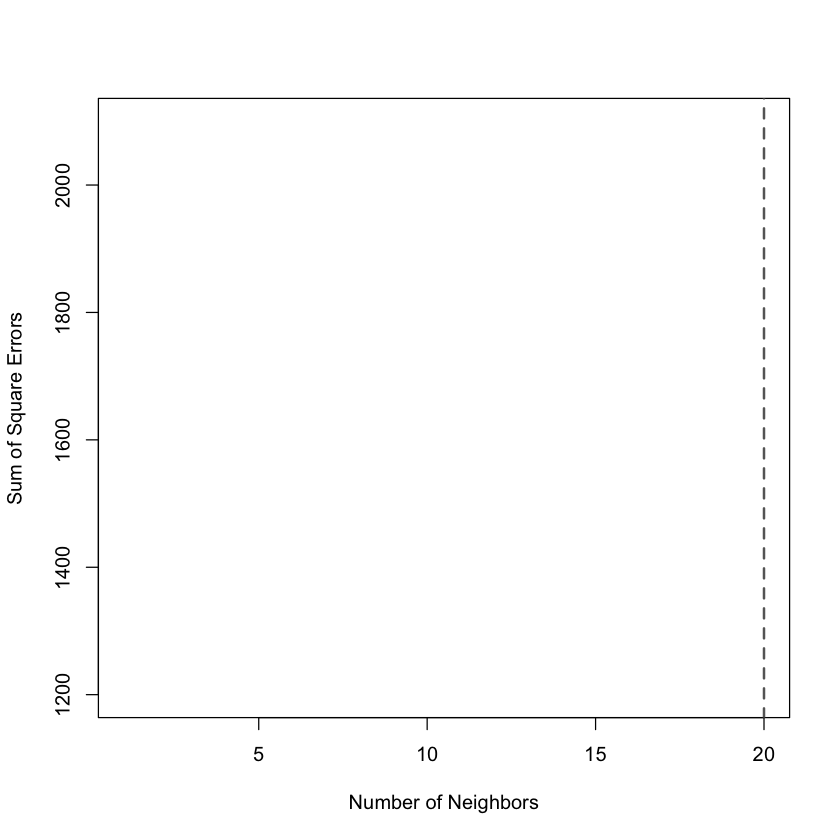

In [303]:
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(1200, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

In [304]:
actualXYRedo = onlineSummaryRedo[ , c("posX", "posY")]

estXYk20_weighted = predXY(newSignals = onlineSummaryRedo[ , 6:11],
                 newAngles = onlineSummaryRedo[ , 4],
                 offlineSummaryRedo, numAngles = 3, k = 3)

errorRateWithBoth_weighted = calcError(estXYk20_weighted, actualXYRedo)
errorRateWithBoth_weighted

[1] 37621

> A K value of 20 was found to be the most optimal when implementing a weighted KNN model. When compared to the error rate of 244.21 from the unweighted KNN model, an error rate of 37620.5203 resulting from the weighted KNN function is astronomical and implies that it is most likely not implemented properly.

# <a name="Conclusion"></a>Future Work, Discussion, and Conclusion

> The lowest error rate coming from utilizing both MAC addresses was a surprising outcome.

> Future improvements include allocating more time towards presenting a polished case study of which I can be proud. Additionally, the weighted KNN is clearly not implemented properly.

# <a name="References"></a>References

1. "Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving." Nolan, Deborah, Temple Lang, Duncan. CRC Press.

2. McGee, Monnie, "Units5and6 - Example R code for Positioning System Case Study." 2016.

3. Slater, Robert, "six_Mac," IPython notebook.

4. Slater, Robert, "Week6" Powerpoint presentation.